Training script for kernel-KL divergence.

$ \mathcal{L}_{KL} = D_{KL}(\Sigma_{p_\theta} || \,\Sigma_\pi) = \text{Tr}\left( \Sigma_{p_\theta} \, \text{log}( \Sigma_{p_\theta} - \Sigma_\pi  )  \right), $

where 

$\Sigma_p = \sum_{x \in \mathcal{X}} \phi(x) \phi(x)^* p(x) $ 

is the kernel covariance embedding with Gaussian kernel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import IQP
from qiskit.circuit import ParameterVector

import pennylane as qml

from src import QCIBM_utilities as ut

In [2]:
nq = 4
#alpha_init = np.array([[1,0],[0.1,0.3]])
#Gamma_init = np.array([1,1])
#Delta_init = np.array([0.5, 0.2])
#Sigma_init = np.array([0,0.1])
#theta_init = ut.compose_params(alpha_init, Gamma_init, Delta_init, Sigma_init)

rng = np.random.default_rng(27031995)

theta_init = np.array((np.pi) * rng.random(int(nq*(nq+3)/2)))
theta = ParameterVector('θ', int(nq*(nq+3)/2))

In [3]:
# Sample hyperparams
p_pi = 0.6
n_train = 500
sampleshots = 500

In [4]:
kernel_params = np.ones(nq+1)*(1/(nq+1)) # eta (uniform)

In [5]:
backend = Aer.get_backend('qasm_simulator')

In [6]:
alpha, Gamma, Delta, Sigma = ut.decompose_params(theta, nq)
qc = ut.QCIBM(alpha, Gamma, Delta, Sigma, nq)
qc = transpile(qc, backend)

In [7]:
# Samples modes
T = 3
ps = 0.4
pi_modes = np.zeros((T,nq)) 
for t in range(T):
    for i in range(nq):
        pi_modes[t,i] = rng.binomial(1, ps)
print('modes = ', pi_modes)

modes =  [[0. 0. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]]


In [8]:
ysamples, pi_vec = ut.sample_target_pdf(n_train, pi_modes, p_pi)
xsamples, phat = ut.sample_circuit( backend, sampleshots, qc.bind_parameters({theta: theta_init}))

In [9]:
#rng = np.random.default_rng(27031995)
proj_nsamples = 512
Ksamples = np.zeros((proj_nsamples,nq))
for i in range(nq):
    Ksamples[:,i] =  rng.integers(0, 2, proj_nsamples)
K = ut.compute_graham_gauss(Ksamples, kernel_params)
delta_ = 10**(-10)
Ksqrt = ut.negsqrtm(K + delta_*np.eye(K.shape[0]))


def L_wrapper(theta_, xsamples):
    L = ut.KL_Gauss_Loss(xsamples, ysamples, kernel_params, Ksqrt, Ksamples)
    return(L)

def grad_wrapper(theta_, xsamples, ysamples):
    nablaL = ut.KL_Gauss_grad(qc, theta, theta_, xsamples, ysamples, backend, kernel_params, Ksqrt, Ksamples)
    return(nablaL)

In [10]:
eta = 0.010 #stepsize
theta_opt, KL_history, TV_history = ut.adam(L_wrapper, grad_wrapper, theta, theta_init, backend, qc, sampleshots, ysamples, batch_size = 250, p_target = pi_vec, tol = -1, maxiter = 400, alpha = eta)
print('θ_opt = ', theta_opt)
print('min Loss = ', KL_history[-1])


 -- Adam Optimization -- Step t =  1
 - Current Loss =  0.3571899227980493
 -- Adam Optimization -- Step t =  2
 - Current Loss =  0.7864037170981497
 -- Adam Optimization -- Step t =  3
 - Current Loss =  0.7136447433397966
 -- Adam Optimization -- Step t =  4
 - Current Loss =  0.4248320093341251
 -- Adam Optimization -- Step t =  5
 - Current Loss =  0.607448472669035
 -- Adam Optimization -- Step t =  6
 - Current Loss =  0.3481142449135397
 -- Adam Optimization -- Step t =  7
 - Current Loss =  0.17149862861406606
 -- Adam Optimization -- Step t =  8
 - Current Loss =  0.16554438752310463
 -- Adam Optimization -- Step t =  9
 - Current Loss =  0.22946802255467325
 -- Adam Optimization -- Step t =  10
 - Current Loss =  0.25085013685497715
 -- Adam Optimization -- Step t =  11
 - Current Loss =  0.24345759168942482
 -- Adam Optimization -- Step t =  12
 - Current Loss =  0.2175611867551548
 -- Adam Optimization -- Step t =  13
 - Current Loss =  0.1938167937903681
 -- Adam Optimiza

 -- Adam Optimization -- Step t =  108
 - Current Loss =  0.03815904860710617
 -- Adam Optimization -- Step t =  109
 - Current Loss =  0.038174072719245
 -- Adam Optimization -- Step t =  110
 - Current Loss =  0.03653227733743991
 -- Adam Optimization -- Step t =  111
 - Current Loss =  0.03636997756754323
 -- Adam Optimization -- Step t =  112
 - Current Loss =  0.03635887296253104
 -- Adam Optimization -- Step t =  113
 - Current Loss =  0.04352762840264468
 -- Adam Optimization -- Step t =  114
 - Current Loss =  0.04574989468676205
 -- Adam Optimization -- Step t =  115
 - Current Loss =  0.0400766692017398
 -- Adam Optimization -- Step t =  116
 - Current Loss =  0.036186604235515674
 -- Adam Optimization -- Step t =  117
 - Current Loss =  0.038632224120732195
 -- Adam Optimization -- Step t =  118
 - Current Loss =  0.03839752300064281
 -- Adam Optimization -- Step t =  119
 - Current Loss =  0.03647933818155713
 -- Adam Optimization -- Step t =  120
 - Current Loss =  0.03725

 -- Adam Optimization -- Step t =  213
 - Current Loss =  0.03644904199440702
 -- Adam Optimization -- Step t =  214
 - Current Loss =  0.03581321872367682
 -- Adam Optimization -- Step t =  215
 - Current Loss =  0.03932025970815656
 -- Adam Optimization -- Step t =  216
 - Current Loss =  0.037135714095980044
 -- Adam Optimization -- Step t =  217
 - Current Loss =  0.036603294703324574
 -- Adam Optimization -- Step t =  218
 - Current Loss =  0.03804196202192034
 -- Adam Optimization -- Step t =  219
 - Current Loss =  0.038983775366404405
 -- Adam Optimization -- Step t =  220
 - Current Loss =  0.04083739920551732
 -- Adam Optimization -- Step t =  221
 - Current Loss =  0.03862132335196433
 -- Adam Optimization -- Step t =  222
 - Current Loss =  0.038429534186602554
 -- Adam Optimization -- Step t =  223
 - Current Loss =  0.03655838387956689
 -- Adam Optimization -- Step t =  224
 - Current Loss =  0.03642374781457702
 -- Adam Optimization -- Step t =  225
 - Current Loss =  0.

 -- Adam Optimization -- Step t =  318
 - Current Loss =  0.036125898089048425
 -- Adam Optimization -- Step t =  319
 - Current Loss =  0.03450995008755764
 -- Adam Optimization -- Step t =  320
 - Current Loss =  0.034245735452818504
 -- Adam Optimization -- Step t =  321
 - Current Loss =  0.03345112203040368
 -- Adam Optimization -- Step t =  322
 - Current Loss =  0.0337014269450393
 -- Adam Optimization -- Step t =  323
 - Current Loss =  0.03383830599938187
 -- Adam Optimization -- Step t =  324
 - Current Loss =  0.03414835243244729
 -- Adam Optimization -- Step t =  325
 - Current Loss =  0.033767617903458724
 -- Adam Optimization -- Step t =  326
 - Current Loss =  0.03540354549581637
 -- Adam Optimization -- Step t =  327
 - Current Loss =  0.03540354549581637
 -- Adam Optimization -- Step t =  328
 - Current Loss =  0.0337378686806864
 -- Adam Optimization -- Step t =  329
 - Current Loss =  0.033275696951725164
 -- Adam Optimization -- Step t =  330
 - Current Loss =  0.03

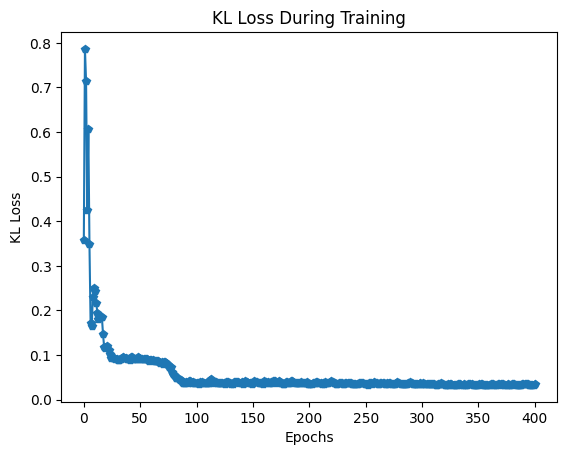

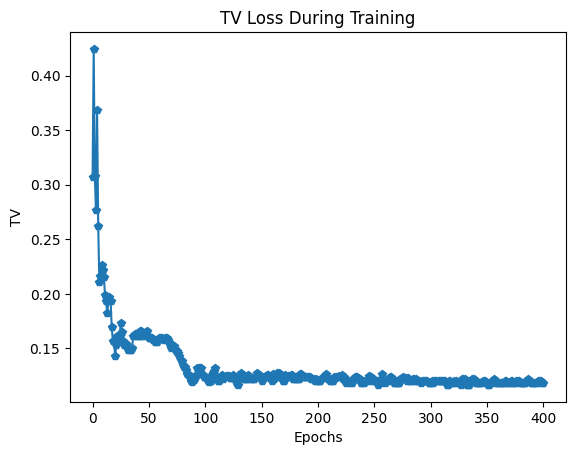

In [11]:
plt.plot(range(len(KL_history)),KL_history, marker='p')
plt.title("KL Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("KL Loss")
plt.show()

plt.plot(range(len(TV_history)),TV_history, marker='p')
plt.title("TV Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("TV")
plt.show()

In [12]:
xsamples, phat = ut.sample_circuit( backend, sampleshots, qc.bind_parameters({theta: theta_opt}))

print('Original samples probs, π = ', pi_vec)
print('Optimized probabilitites, p(θ)= ', phat)

Original samples probs, π =  [0.0912     0.0848     0.0608     0.05653333 0.0768     0.0672
 0.0512     0.0448     0.0768     0.0672     0.0512     0.0448
 0.0752     0.0608     0.05013333 0.04053333]
Optimized probabilitites, p(θ)=  [0.064 0.08  0.038 0.048 0.084 0.044 0.028 0.048 0.068 0.082 0.062 0.058
 0.082 0.094 0.064 0.056]


['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


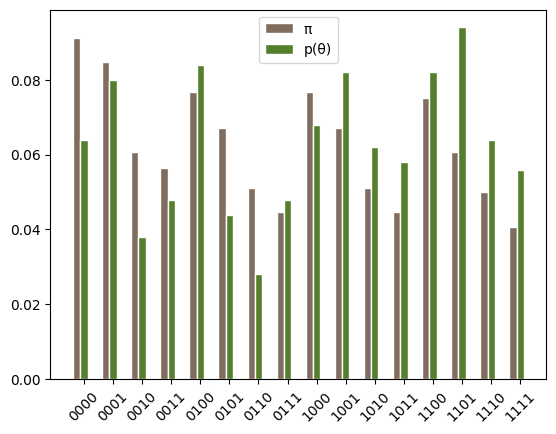

In [13]:
xlabels = []
for j in range(2**nq):
    xlabels.append(ut.binstr_from_int(j,nq))

print(xlabels)

barWidth = 0.25
 
r1 = np.arange(len(pi_vec))
r2 = [x + barWidth for x in r1]
plt.bar(r1, pi_vec, color='#7f6d5f', width=barWidth, edgecolor='white', label='π')
plt.bar(r2, phat, color='#557f2d', width=barWidth, edgecolor='white', label='p(θ)')
plt.xticks([r + barWidth for r in range(len(pi_vec))], xlabels, rotation=45)
plt.legend()
plt.show()

In [14]:
#path = '/home/alb/Scrivania/Quantum/Projects/BornMachine/data/'
#np.savetxt(path+'KLGaussTraining4qb400italpha010_theta_opt.csv', theta_opt, delimiter=',')
#np.savetxt(path+'KLGaussTraining4qb400italpha010_KL_history.csv', KL_history, delimiter=',')
#np.savetxt(path+'KLGaussTraining4qb400italpha010_TV_history.csv', TV_history, delimiter=',')